#Churn Case Study

##Introduction and Motivation
<p>In this notebook we present an end-to-end analysis on a data mining task that is fairly common in the field. Most companies that provide subscription (whether free or not) services face the issue of customer churn. This is loosely defined as customers disengaging with the company's service, and in many cases, no longer paying for monthly or yearly fees. This issue is pervasise across industries (such as Telecom, Media, Music/Video Streaming, Gym Memberships, Credit Cards, Insurance, etc.), and it is common to find entire departments focusing on improving churn rates. 

<br><br>
Churn reduction is a perfect environment for employing data mining techniques. Most companies maintain very detailed customer databases that host all of the data required to predict churn. An analysis of customer churn usually involves exploring the drivers of churn as well as predicting the likelihood. The goals are often multi-fold: on one level, predicting churn enables companies to proactively reach out to at-risk customers to prevent it. Additionally, understanding the drivers (re: causes) of churn gives valuable feedback for the company to improve the underlying product or service issues that may be causing customer dissatisfaction.

<br><br>
This notebook more than anything aims to illustrate a complete data mining workflow. Churn is the application but the emphasis here is on the steps one might take when perfoming a data mining task. There is Python code that generates the models and illustrations shown, but the emphasis here is more on the process than the code, so the code will mostly be hidden behind unexposed functions. We also provide generous discussion on how the results of the various analyses impact decisions one would make when focusing on churn reduction. 
</p>

##Outline
<p> Using a relatively straightforward churn dataset, we cover the following steps:
<ul>
    <li>1. Problem Formulation</li>
    <li>2. Data understanding and exploration</li>
    <li>3. Model building and model selection</li>
    <li>4. Evaluation</li>
    <li>5. Deployment</li>
</ul>

</p>


##Problem Formulation
<p>The first thing we should, as this guides the design of the entire analysis, is define the problem more formally. We know in general we want to reduce churn for the telecom firm. This could be implemented in several ways across the firm. 
<br>
<ul>
    <li>Proactively reach out to customers with a high likelihood of churn.</li>
    <li>Create a reactive strategy, where we triage customers who call in based on their likelihood to churn.  </li>
    <li>Study the data to gain insights into drivers of churn.</li>
</ul>
<br>
The first two use cases suggest that we need to be able to rank customers based on their churn risk. Given that we have a binary outcome of interest, we know that we can apply some form of supervised learning to solve this problem. An important question is, do we want to only just rank, or do we want to rank and compute probabilities of churn? The answer here has implications over what type of supervised algorithm we will use. 
<br><br>
For our specific task, we're going to choose an algorithm that can produce probabiliy estimates of churn risk for each customer. This should not restrict us in any way that prohibits us from exploring multiple classes of algorithms. Additionally, being able to esimate probabilities offers us greater flexibility in incorporate our models into calculating any expected value of applying various intervention strategies. So to put it more formally, our tasks will be the following:<br>
<ul>
    <li>1. Use available data to build a supervised learning algorithm that estimates the likelihood of churn, $P(Churn|X)$</li>
    <li>2. Develop insights using the model and data to inform business constituents about drivers of churn  </li>
    <li>3. Develop a framework for incorporating our probability estimates into one or more intervention strategies to reduce overall churn.</li>
</ul>

</p>


##Data Exploration

<p>The first thing one should do when starting an analysis is understand the data. "Data understanding" can represent multiple things of course. Here are some common questions to ask when approaching a data set:
<br><br>
<b>How was the data sampled, collected and aggregated?</b><br>
Unless you planned and executed every step of the data sampling, logging and transformation processes, you should always spend some time exploring this question. The best analyses can be sabotaged by poorly sampled and logged data, so a data scientist always needs to understand what biases may exist in the data. The data for this churn analysis is comprised of all churners + a subset of non-churners, sampled so that there is a roughly even distribution between the two groups. Each sampled customer is represented by a vector of predictors $X = <X_1, X_2, ..., X_k>$ and an outcome $Y$. 
<br><br>
When creating a dataset for churn modeling and analysis, one has to be mindful of the future application of the results. I.e., we don't want to predict <i>past</i> churn, we want to predict potential <i><b>future</b></i> churn. In building a data set to predict future churn, one can sample customers today and wait some period of time to observe whether or not the consumer churns. While this is technically accurate, you might not want to wait what could be weeks or months to start the analysis. Additionally, you might want to study several cohorts of sampled customers so your analysis isn't biased towards any time/seasonal dependent factors that are happening at the moment. The other option then is to simulate the future by going into the past. The following scheme shows how this is done:
</p>


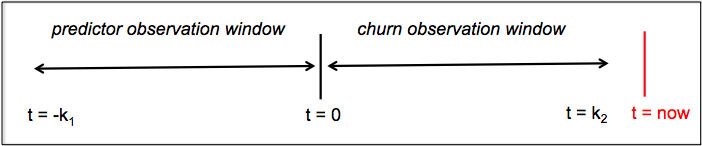

In [6]:
from IPython.display import Image
Image(filename='references/churn_sampling_scheme.png') 

<p>The point "t=now" is the day you're doing the analysis. We need to go back in time and create a virtual present, which we call $t=0$. We then look backwards to aggregate the predictor variables, and we look forwards in time to observe churn. The above represents one cohort, but this can be replicated across multiple cohorts (or multiple dates considered $t=0$ to either get access to more data or build dataset that has less dependency on any single seasonal effect). 
<br><br>

<b>What are the variables in the dataset?</b><br>
This is a simple question with a lot of implication behind it. Before digging into the distribution of the variables, one should first understand what they are from a domain perspective. Technically, you can build a model having no qualitative understanding of the data set. This works fine in homework assignments or data mining competitions. In industrial settings however, having the contextual and qualitative understanding of the data is generally critical to conducting an effective analysis, and even more critical in communicating and applying the results. The following links to a schema for the dataset we'll be using:
<br><br>
<a href="https://github.com/briandalessandro/DataScienceCourse/blob/master/ipython/references/churn_dataset_info.pdf">Churn Data Schema</a>
<br><br>
Each of the independent predictor variables represents either some static demographic of the customer, or a summary of some aspect of the customer's usage of a cellular phone service (where the summary ends at time $t=0$).
<br><br>
An important question to highlight at this point is: <i><b>why are we using these specific variables?</b></i>
<br><br>
The implications of this question are often the difference between a decent model and a great model. Separate from the more technical topic of variable selection, is the topic of feature engineering (note: a "variable" and a "feature" are generally the same thing, but the more common phrase is "feature engineering"). The variables in this dataset were conceived and programmed by someone, and this part of the process is as much art as it is science. Most data infrastructure systems are designed to accommodate fast, production-level transaction processing. Analytics and modeling is often a secondary consideration. A data scientist is often responsible for pulling raw, log-level data from the transaction systems and designing the feature engineering pipelines that turn raw data into modeling variables. Designing the right variables requires domain knowledge of the system and insight into the behavior one is trying to predict. In this case, we'll assume that someone with deep knowledge of the problem has designed these specific variables with the hypothesis that these would both be effective predictors and scalable to create. Data scientists often find themselves working with pre-existing modeling systems. A very common research question is what new variables can be added to the existing set to improve prediction performance (note: we won't actually be covering this question in this case study)?  
<br><br>
<b>What does the data look like?</b><br>
This is where we start to explore the data from a quantitative perspective. More formally, we want to gain an understanding of the joint distribution of $X$ and $Y$ (because this is ultimately a predictive modeling problem, we follow convention and label the dependent variable/outcome $Y$). We'll focus here on three aspects of the joint distribution: 1). descriptive statistics of each variable, 2). covariance of the predictors, 3). covariance of each predictor with the outcome. Within each aspect we'll cover implications of the results. 
</p>

###Descriptive Statistics

<p>The first thing we'll do is look at descriptive statistics of the data. Common statistics to look at are the mean, variance, range, and distribution (via the various quantiles of the distribution).

</p>

In [1]:
import sys
sys.path.append("./utils/")
from course_utils import *
import churn_analysis as churn
from IPython.display import display, HTML
reload(churn)

data = pd.read_csv('/Users/briand/Desktop/ds course/hw/Cell2Cell_data.csv', header=0, sep=',')
data_descr = churn.getDfSummary(data)
HTML(data_descr.to_html())

,mean,std,min,25%,50%,75%,max,missing,distinct
revenue,58.633816,44.142467,-5.86,33.37,48.37,70.93,861.11,0,11617
outcalls,24.874208,34.702038,0.00,3.00,13.00,33.33,610.33,0,738
incalls,8.011796,16.626837,0.00,0.00,2.00,8.67,519.33,0,434
months,18.789332,9.594723,6.00,11.00,16.00,24.00,61.00,0,56
eqpdays,391.935723,255.609575,-5.00,212.00,341.00,530.00,1823.00,0,1396
webcap,0.895456,0.305968,0.00,1.00,1.00,1.00,1.00,0,2
marryyes,0.365338,0.481531,0.00,0.00,0.00,1.00,1.00,0,2
travel,0.057101,0.232039,0.00,0.00,0.00,0.00,1.00,0,2
pcown,0.185378,0.388609,0.00,0.00,0.00,0.00,1.00,0,2
creditcd,0.675908,0.468041,0.00,0.00,1.00,1.00,1.00,0,2


<p>Putting in tabular form is convenient and allows for easy comparison. The table here shows the descriptive statistics we discussed above, and also includes useful points such as count of missing values and the cardinality of the data. This last point is helpful for identifying which are binary variables. 
<br><br>
<b>So what is the use of looking at this data?</b><br>
Just glancing at the above, we can make the following observations of the data:
<ul>
    <li>The data contains no missing values. This is fortunate, but we're not always this lucky.</li>
    <li>Two of the variables have records with negative values. There could be legitmate reasons for this, but intuitively this seems off and would be worth looking into. If discovered to be a data error, we may want to remove these records or replace the negative value with a more meaningful value.</li>
    <li>The non-binary features are on different scales. This could be an issue with certain classification algorithms, and would require standardization prior to modeling.</li>
    <li>Some of the variables (eqpdays, outcalls and incalls) are highly skewed (i.e., we see top quantiles and max that are much farther from the mean than the bottom quantile and min). If we need to use certain parametric classification algorithms (logistic regression, SVM), we may want to replace the existing variables with a few variable transformations (i.e., log(X), or binning).
</ul>
</p>

###Variable Covariance
<p>Another useful exploratory technique is to understand the correlation of the variables. If the dimensionality of the data is reasonable enough (a very subjective call admittedly), we can visualize the correlation matrix in a nicely intuitive way:

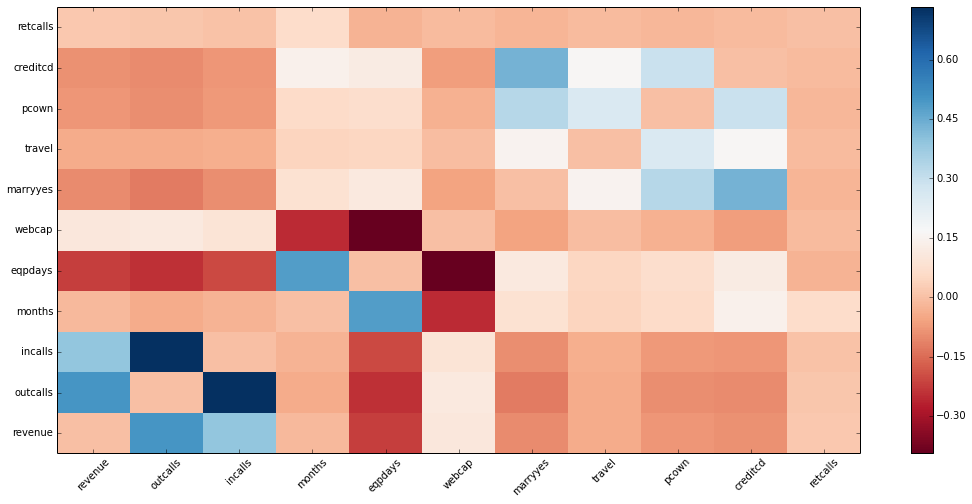

In [2]:
%matplotlib inline
reload(churn)
churn.plotCorr(data, 'churndep', 18, 8)


<p>The above illustration let's us quickly see which variables have high degrees of correlation amongst themselves. In particular, we see that 'incalls' and 'outcalls' have alarmingly high correlation. Intuitively this might make sense, as someone who makes frequent calls would also be more likely to receive more calls. An important question of course is, does this matter? The answer of course (and this is the answer to many data science questions), is it depends. In general, we usually want to be cautious when several variables are highly correlated (and even more so if they are collinear). Certain supervised learning algorithms, such as tree-based algorithms, can automatically deal with highly correlated variables. Tree-based algorithms are particularly good at handling data 'as-is,' and one might choose to use them based on that property. However, many industrial systems are built around linear models, such as logistic regression. These algorithms are definitely sensitive to data irregularities, and can certainly give strange results when two or more features are highly correlated. <br><br>

For the purpose of this case study, we're going to assume that we don't have restrictions on our choice of supervised learning algorithm. We can thus think ahead and acknowledge that our final model may likely be tree based, and as a consequence we won't explicitly correct for the high degree of correlation present here. If we wanted to though, some possible solutions could be simply dropping one of the correlated variables, or transforming the data using Principal Components. 
</p>

###Targeted Exploration

<p>Above we looked at how the various predictor variables correlated with each other. That is an exercise with its own motivation and implications. When faced with a supervised learning task, we often also care deeply about how all of the covariates correlate with our outcome of interest. This step of exploratory analysis has several benefits.<br>
<ul>
    <li><i><u>Pre-filtering of variables:</u></i>  In many cases we want to reduce the dimensionality of the dataset prior to modeling. In general, there is no sense in keeping variables that have no relationship with the outcome.  </li>
    <li><i><u>Early insights:</u></i> We may want to report back progress to our business partners sooner than later. This step of the analysis will help us get early clues as to what are the primary drivers of churn.</li>
</ul>




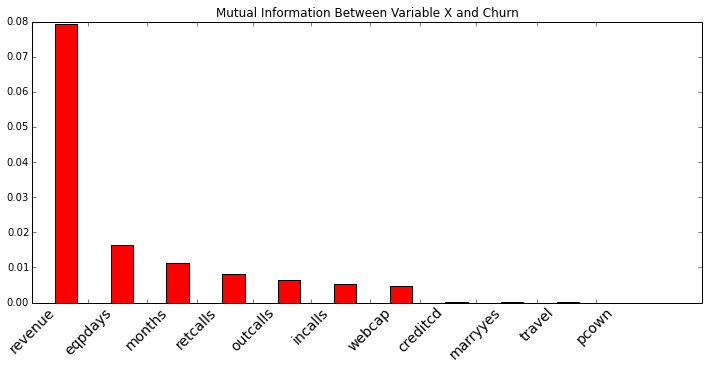

In [3]:
reload(churn)
churn.plotMI(data, 'churndep', 0.4)
plt.title('Mutual Information Between Variable X and Churn')

<p>This chart makes it pretty obvious which variables have a more correlated relationship with the churn outcome. For this analysis, we can ignore the absolute value of the mutual information and focus more on the relative values. Of the 11 variables, 3 look like they carry very little information about the Churn outcome. Of the remaining 8, 'revenue' clearly is the leader by far. This is interesting, but to truly interpret this, we need to know one more piece of information - does the variable in question have a positive or negative relationship with Churn? One issue with Mutual Information is that it doesn't tell us this piece. <br><br>

With a little hacking, we can show the same plot but color the bars accoring to the direction of the correlation. 
</p>

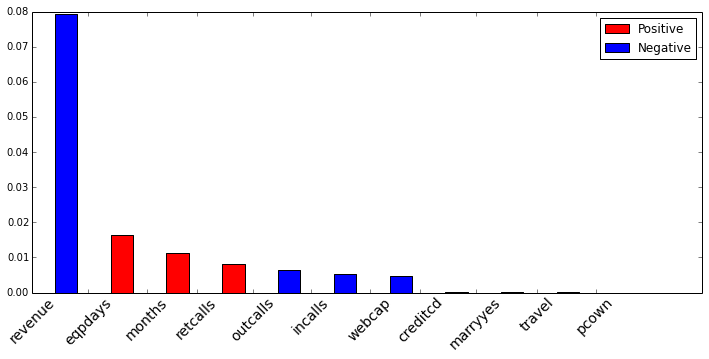

In [4]:
churn.plotMI(data, 'churndep', 0.4, 1)

<p>The above chart shows Mutual Information, but with the bars colored according to the direction of the correlation. So to read this, we can say that as 'revenue' increases, the likelihood to churn goes down. We'll leave it as a thought experiment for the to do the following: "How would you explain the qualitative implications of this chart to your marketing colleagues?"
</p>

##Predictive Modeling

###Setup

<p>At this stage we should have a strong sense of where our data came from and what the data looks like. We know from our planning that we aim to learn a supervised model with a binary outcome. When we set up the problem, we set it up without specifying any specific constraints around the learning algorithm we can use. There are many industrial situations where one might only be able to choose from a small class of algorithms. This could be motivated by scalability concerns, legacy issues or regulatory mandates. <br><br>

This is the stage where we need to decide whether or not to act on any of the data learnings we have observed above. We know we have at least one highly redundant feature as well as three features that seem to have no relationship with our outcome. If we were constrained to using a linear model like logistic regression, we would definitely want to consider dropping these variables. We know though that we have the allowance to use many more sophisticated tree-based algorithms, which conveniently enables us to just use the data as is. Nonetheless, we'll test in this study the effect of dropping these variables. 
</p>

###Modeling Plan
<p>Building the final model is one area where we can put the 'science' in data science. Specifically, choosing a model can be thought of as running a controlled experiment against the multitude of design options that can be built into modeling process. It generally helpful to be organized and specify the exact modeling options we will test. Here is the plan for this dataset:<br><br>

<b>Modeling Design Parameters</b>
<ul>
    <li><b>Algorithms:</b> [Gradient Boosted Tree, Random Forest, Decision Tree, Logistic Regression]</li>
    <li><b>Hyper-parameters:</b> Each algorithm has its own set of applicable hyper-parameters. We'll choose a grid of parameters that makes reasonable sense for each algorithm.</li>
    <li><b>Variables:</b> All vs. All - {'incalls', 'creditcd', 'marryyes', 'travel', 'pcown'}</li>
</ul><br>
<b>Evaluation Plan</b><br><br>

<u><i>Splits</i></u><br>
You can't compare modeling options if you don't have a clearly articulated evaluation plan. We have a reasonably large dataset, with relatively few variables and balanced class distribution. We should consider ourselves spoiled (or at least lucky), that this is the case. The first decision we have to make is how to split the data. There is no time index, so we can just randomize across users. Because we have sufficient data, we would likely be fine creating three splits: training, validation, and testing. If we went this route, splits around 70%, 20%, 10% would likely do (remember, this particular decision is rather heuristic). 
<br><br>
We don't have any particular constraints around modeling time, and the data isn't too large, so we'll go the extra mile and run cross-validation to do modeling selection. In cross-validation, we need a train/test split, and we can go 90%/10% for this. One advantage of cross-validation is that we can get variance estimates of our validation results, which gives flexibility in designing more conservative modeling selection rules. And on a practical note, we have to make sure we use the same exact cross-validation splits for each algorithm + hyper-parameter option. 
<br><br>

<u><i>Evaluation Metric</i></u><br>
Choosing the right evaluation metric is a critical decision whose importance is often overlooked. Specifically, we get to choose the evaluation metric used in validation. The training metric, which guides the empirical risk minimization algorithm in training, is often dicated by the algorithm (and is usually different for each algorithm).
<br><br>
The right metric should be guided by the application. Our example here has two potential applications: 1). to rank candidates according to likelihood to churn, and 2). to estimate good churn probabilities. The AUC would be an appropriate metric if we were just considering case (1), but we'll choose the LogLoss because of case (2). We'll discuss later how to create an expected value framework for putting our churn model into action. Before that though, we can say that a good churn probability estimator is a key element in computing expected values, and thus we'll choose the LogLoss.<br><br>

<b>So now let's get onto the modeling!</b><br><br>

Below is the most Python that we'll show in this case study. The code does a lot in just a few lines, and it shows pretty clearly the algorithms and hyper-parameters we're going to consider.
</p>

In [187]:
#Here is the grid of hyper-parameters will test for each algorithm
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import KFold


models = {LogisticRegression():{'C':[10**i for i in range(-2, 5)], 'penalty':['l1', 'l2']},

          GradientBoostingClassifier():{'learning_rate':[0.005, 0.01], 'n_estimators':[200, 500],
                                      'max_depth':[3], 'subsample':[0.5]},

          RandomForestClassifier():{'n_estimators':[200, 500, 1000], 'criterion':['entropy']},

          DecisionTreeClassifier():{'min_samples_leaf':[20, 50, 100], 'criterion':['entropy']}}


#1. Split the and prepare data
train_all, test_all = trainTest(data, 0.9)
train_subset = train_all.drop(['incalls', 'creditcd', 'marryyes', 'travel', 'pcown'], 1)
test_subset = test_all.drop(['incalls', 'creditcd', 'marryyes', 'travel', 'pcown'], 1)

kfolds = KFold(train_all.shape[0], n_folds = 5)


#2. Start the model bakeoff 

best_models_all = {}
best_models_sub = {}

Y = 'churndep'

for classifier in models:
    
    best_models_all[classifier] = GridSearchCV(classifier, models[classifier], cv = kfolds, scoring = 'log_loss') 
    best_models_sub[classifier] = GridSearchCV(classifier, models[classifier], cv = kfolds, scoring = 'log_loss') 
    
    best_models_all[classifier].fit(train_all.drop(Y, 1), train_all[Y])     
    best_models_sub[classifier].fit(train_subset.drop(Y, 1), train_subset[Y])

    
#3. We just need to save the summaries.  The actual GridSearchCV objects contain a lot of data that we don't need to keep in memory    
summ_all = {}
summ_set = {}

for k in best_models_all:
    summ_all[k] = [best_models_all[k].best_params_, best_models_all[k].grid_scores_]
    summ_set[k] = [best_models_sub[k].best_params_, best_models_sub[k].grid_scores_]


<p>Now let's plot the results of each algorithm against each other
</p>

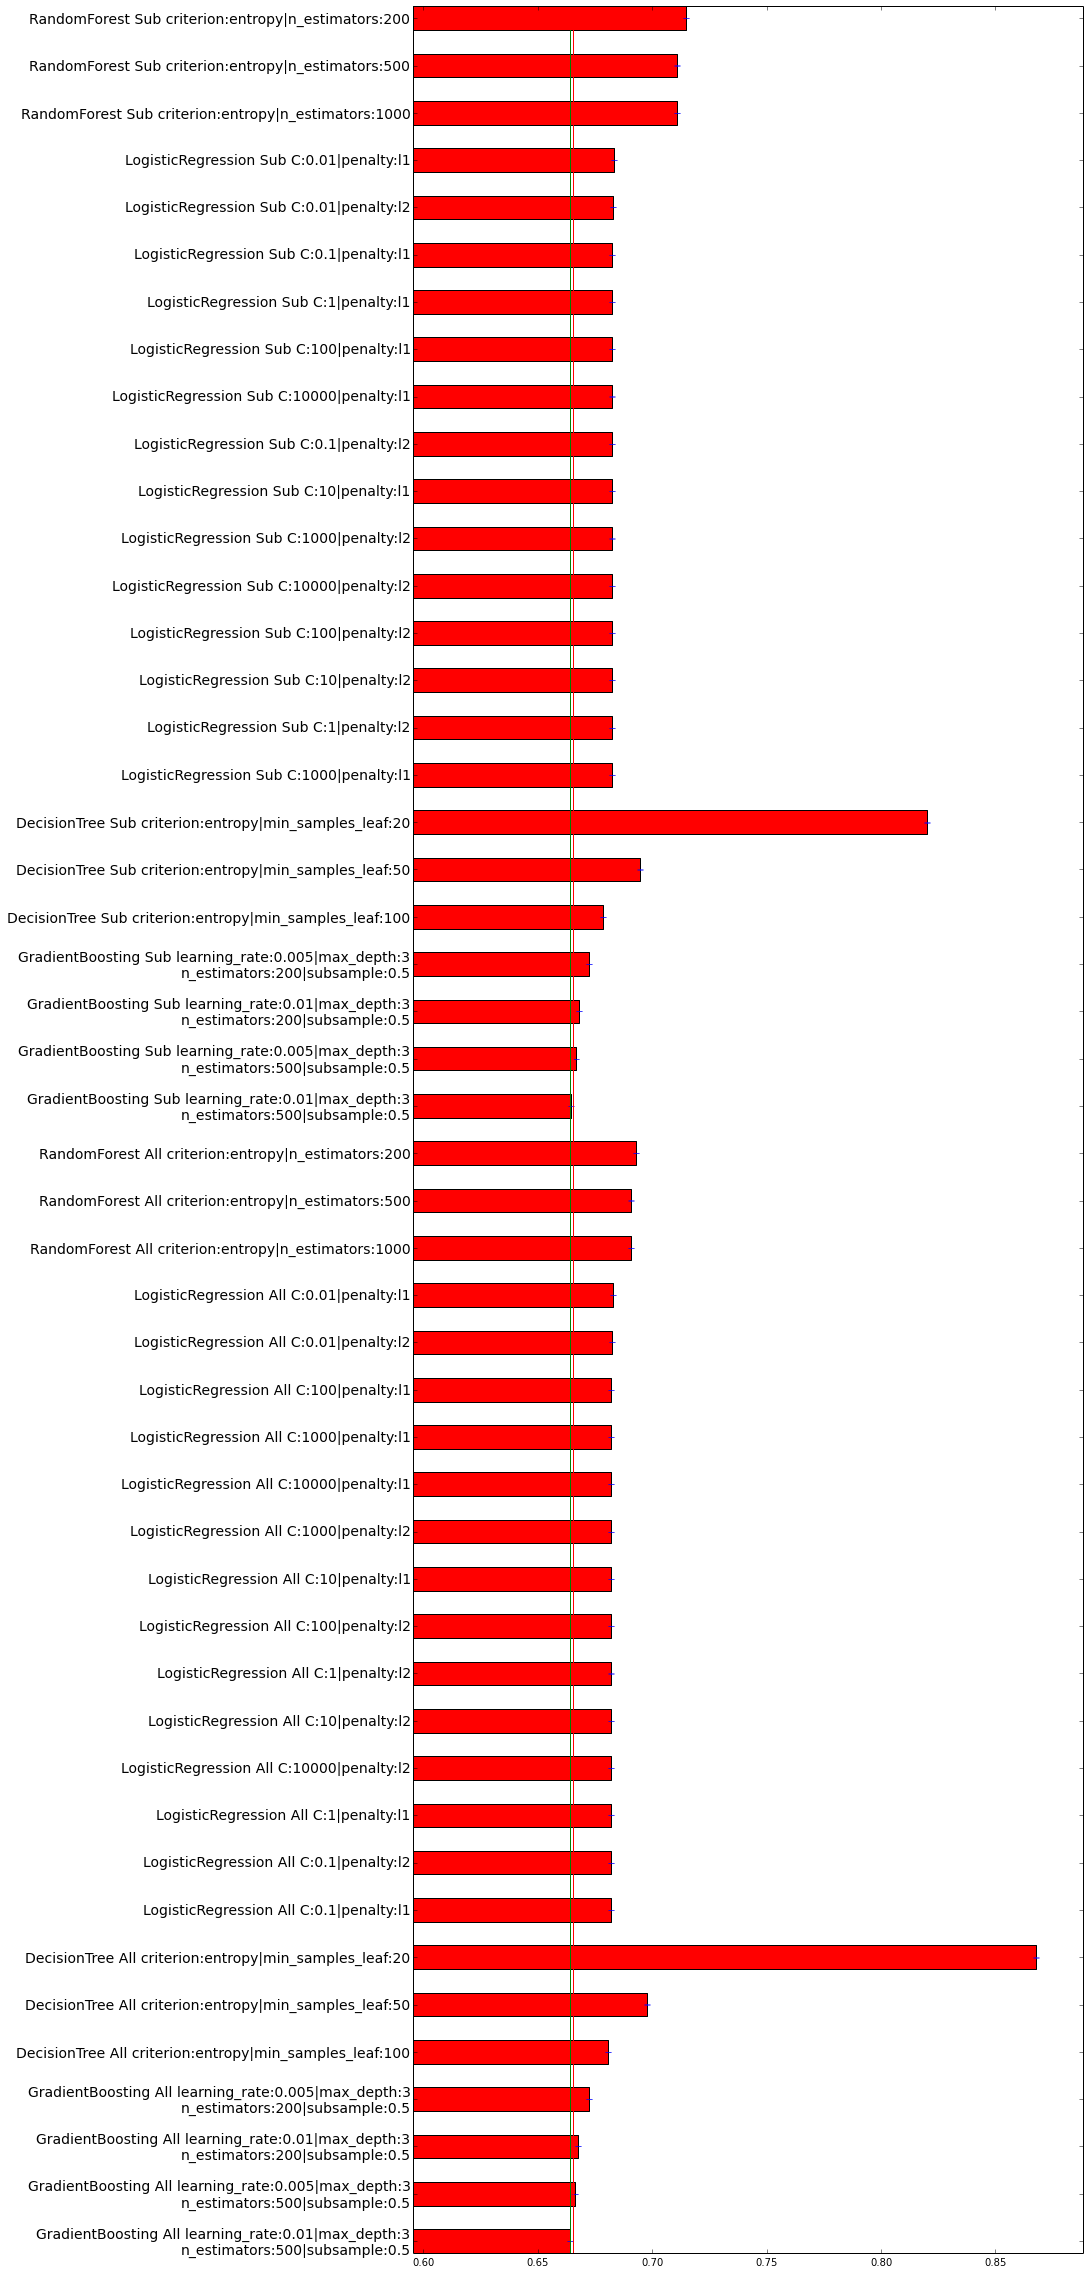

In [325]:
reload(churn)
churn.plotGridSearchMulti([('All', summ_all), ('Sub', summ_set)], True)

<p>The above bar chart shows the cross-validation results of all algorithms testedand their respective hyper-parameter configurations. For convenience, we plotted two reference lines. The green line is just the LogLoss of our best classifier. The red line is the value of the best option plus 1 standard error of the mean of that option. The red line gives us the ability to choose a classifier using the 1-Standard Error rule, a generally good rule of thumb for being more conservative in one's selection. In our case here, the optimal option uses all of the data, but the option using the same algorithm and hyper-parmaters on less data is well within the 1-standard error here. When selecting a model, we generally want to promote parsimony (i.e., don't let things be more complex than they need to), so we'll go with the option that uses less data.  In the long-run, this could have multiple benefits: 1). cheaper to execute and maintain, 2). less over-fitting risk. <br><br>

Now let us refit the model on the entire training set do evaluations on the test set.
</p>

In [404]:
lab = 'churndep'
best_model = GradientBoostingClassifier(n_estimators = 500, max_depth = 3, learning_rate = 0.01, subsample = 0.5)
best_model.fit(train_subset.drop(lab, 1), train_subset[lab])

GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=3, max_features=None, min_samples_leaf=1,
              min_samples_split=2, n_estimators=500, random_state=None,
              subsample=0.5, verbose=0)

##Evaluation
<p>We discussed above that our core metric here will be LogLoss. This worked well for model selection, however, simply looking at the value of the LogLoss metric without any reference points isn't always helpful. Our main motivation for using LogLoss was that we ultimately want good estimates of churn probabilities. One tool for understanding how well we achieved this goal is the probability calibration plot. Our evaluation plan will be to start with calibration plots. For additional insight into our model capabilities, we'll also produce a lift chart. The lift chart is a good evaluation tool that is fairly accessible to non data scientists.


</p>

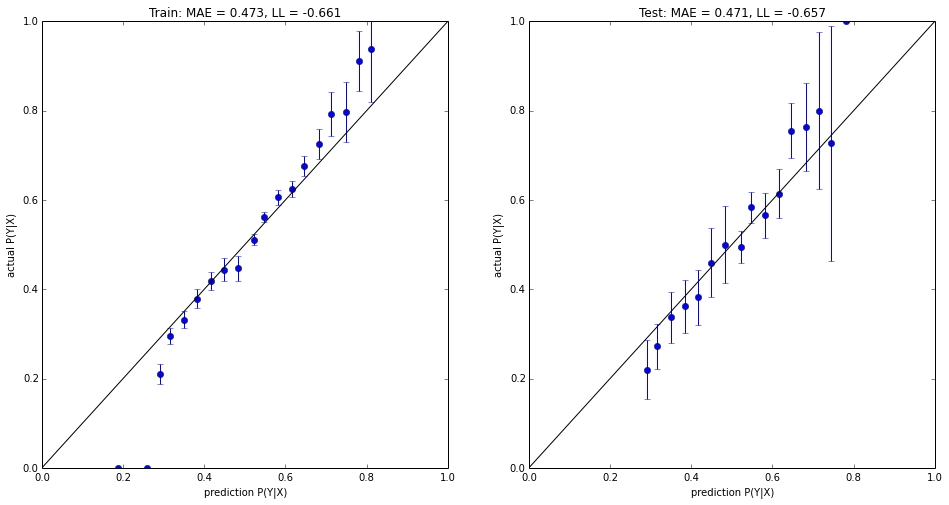

In [405]:
preds_train = best_model.predict_proba(train_subset.drop(lab,1))[:, 1]
preds_test = best_model.predict_proba(test_subset.drop(lab,1))[:, 1]

val.plotCalib(train_subset[lab].values.ravel(), preds_train, bins = 30, f = 4, l = 'Train', w = 16, h = 8, 
                fig_i = 1, fig_j = 2, fig_k = 1)

val.plotCalib(test_subset[lab].values.ravel(), preds_test, bins = 30, f = 4, l = 'Test', w = 16, h = 8, 
                fig_i = 1, fig_j = 2, fig_k = 2)

<p>

<i><b>Interpreting the calibration plots</b></i>
<br><br>
Remember, the point of the calibration plot is to understand whether or not our probability predictions actually result in probabilities that are near the prediction. Because we want to use our model predictions to estimate expected values, we want the calibration plot to be as close to the identity line as possible. Our main focus should be on the right chart above, which shows results for our out of sample dataset. The dominant trend we see here is that for the extremes (lower and higher estimated probabilities), our estimator tends to be more conservative. I.e., it underestimates the higher probabilities and overestimates the lower probabilities. We plot the 95% confidence intervals of the empirical probabilities (y-axis), and most of these overlap with the identity line. However, this might just be driven by sample size. We can see the same trend in the training, where the sample sizes are sufficient. <br><br>

<i>What should we do about this?</i><br><br>

When model calibration is an issue, we can deploy one of two tools to correct the problem. The first is a non-parametric method called Isotonic Regression, and the other is a parametric method called the Platt Correction. More details of these methods (in sklearn) can be found <a href="http://scikit-learn.org/stable/modules/calibration.html#calibration">here</a>. Because our calibration error here is very mild, we'll hold off on running these corrections for now. This topic will be shelved in our 'further research' to-do list.  <br><br>

We'll now make a secondary evaluation using lift and recall curves. These curves can help us answer other questions about our model, and they are generally accessible to non data scientists.

</p>

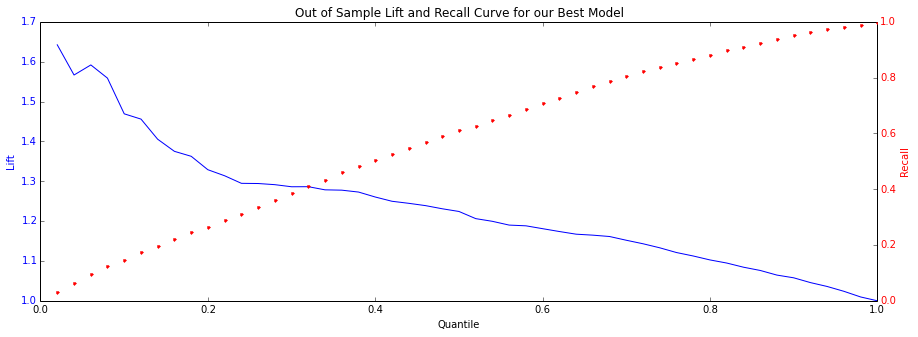

In [428]:
lt = val.liftRecallCurve(pred, truth, 50, h = 5, w = 15, 
                         title = 'Out of Sample Lift and Recall Curve for our Best Model')


<p>

<i><b>Interpreting the lift and recall plots</b></i>
<br><br>
These plots look pretty normal and they don't suggest any major hiccups or issues with our model. Apart from being diagnostic, they can help answer questions that might come up when we apply our model. For instance, if we wanted to design an intervention for the most at-risk churners, we'll of course need to choose a cut-off point. There are advanced ways to do this (we'll discuss this later), but one could be to reach out to the at-risk churners subject to some budget constraint. For instance, we might have a call center that can reach out to 20% of the customer base up for renewal. If we chose our cut-off as the top 20%, then with the recall plot we could see that we'd be reaching about 34% of the would be churners. Using the lift curve, we could say that this would make us about 36% more efficient at reaching would be churners than if we had just randomly reached out to people. 
</p>

##Deployment

<p>Since this is a case study motivated by a single, static dataset, we cannot actually deploy our churn prediction model. However, we can certainly consider how we might intend to put the model to use. There are many important considerations when deploying a prediction model in an industrial application. They two we'll discuss specifically are:

<ul>
    <li>How do we incorporate model output into a decision making framework?</li>
    <li>How might we implement the model to support production level systems?</li>
</ul>

<br><br>
<i><b>An Expected Value Framework for Churn Reduction</b></i>
<br><br>
The most important point to remember when doing data science is that a great prediction model doesn't alone solve our problem. Ultimately, the value we get from data and analytics comes from doing things differently because of that very data and analytics. One common way to use a model in churn reduction is to proactively reach out to at-risk customers with some form of an intervention strategy. Example interventions might include a personalized call from a customer service rep or an email with some targeted message. Beyond establishing a conversation with the customer, our interventions might likely include some special offer or discount that reduces the financial obligations of the customer. <br><br>

It is pretty likely that any of our intervention strategies would come with some form of risk. Example costs that we might occur are: 1). the expense of calling someone from a call center, 2). annoying a user with too much email, 3). giving someone a discount or special offer when they indeed had no intention to churn. While all of these are important, the last point is likely the one that could have the biggest impact on overall revenues. We need to design a logical system here to choose when and when not to intervene. We can use expected values to design such a system. 
<br><br>
The two main ingredients to our expected value formulation are the likelihood of the customer churning, and the expected lifetime value of the customer if (s)he should not churn. We'll call these $P(Y=1|X)$ and $E[LTV|X, Y=0]$. Note that we defined these conditional on the user attributes $X$, as this is how our churn prediction model is defined. Now let's define a variable $A \in \{0,1\}$, where $A=1$ means we perform an intervention, and $A=0$ means we don't. <br><br>

Our goal here is to maximize the expected lifetime value of each customer. For now, we have one decision lever - to intervene or not. From here, the decision apparatus is quite simple: intervene if doing so results in a higher expected value for the customer! In more formal terms, on each user with features $X=x$, intervene if:<br><br>

<center>$(1 - P(Y=1|X=x, A=1))*E[LTV|X=x, Y=0, A=1] > (1 - P(Y=1|X=x, A=0))*E[LTV|X=x, Y=0, A=0]$</center>

<br><br>
Defining this decision rule both formally and informally is quite straightforward. Actually estimating it on the other hand is actually not at all straightforward. Our churn model (the focus of all of the above analysis), takes care of the quantity $P(Y=1|X, A=0)$, but will this estimate reflect churn probabilities if we decide to intervene? Sadly, the answer is likely no. To get an accurate estimate of $P(Y=1|X=x, A=1)$, we need to actually intervene on a set of users and test the effect of the intervention. This basically suggests we should design a controlled experiment and spend some resources collecting the appropriate data (see, the modeling is just one part of the process). <br><br>

Additionally, we need to estimate accurate lifetime values (for now, we'll fold the cost of the intervention into the LTV). This is a highly non-trivial task, and doing it in a timely manner might require making many simplyfying assumptions. As this step is out of scope for this case study, we'll leave it as a discussion point. But for any reader deploying such a system in a real company, this is certainly a step that shouldn't be ignored.<br><br>


<i><b>A Simple Production Scoring Architecture</b></i><br><br>

Every deployed prediction modeling system has at least two components. These are the training module as well as the scoring module. Remember, it is through the application of the model that data and predictive analytics will add value, so the scoring system is critical to get right. Firms often have to make a decision whether or not to automate a modeling and scoring system. The right answer is ultimately company and project specific, but let's assume that for our company here we're interested in tackling the scoring system first. <br><br>

Before writing any production code, we'll want to design a basic architecture for the system. In doing this, we'll want to specify the data dependencies, the data schemas and the process flows. We need to start by understanding and articulating our use cases. Given a working churn prediction model, we need a system that can support two cases: 1). periodically create lists of at-risk churners for proactive outreach, 2). look up churn risk for in-bound call center requests. An example of such an architecture is here:


</p>


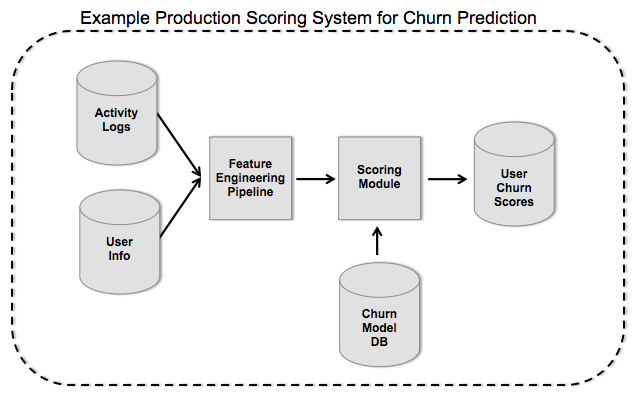

In [431]:
Image(filename='references/churn_scoring_architecture.png') 

<p>Here is a quick description of each component in the above:<br>
<ul>
    <li>Activity Logs & User Info - These are the raw data systems that will ultimately be processed into modelable features</li>
    <li>Feature Engineering Pipeline - This is the code that transforms raw log and data base information into structured model features. This pipeline should be identical to that used in the training phases</li>
    <li>Churn Model DB - This is a data store that holds the actual prediction models (whether they be coefficients of a logistic regression, rules from a decision tree or python classifier objects)</li>
    <li>Scoring Module - This module takes in structured features of a user and a model to produce a prediction.</li>
    <li>User Churn Scores - This is a database that holds the most recently updated user churn prediction score.</li>
</ul>
<br>
At this stage of implementation a lot of decisions will have to be made, such as, do we need to score users in real time or will some periodic batch update suffice? These are all application specific, but they do have implications for how the system and schemas are designed (not to mention what data storage systems will be used). <br><br>

<i>Extending our system</i><br><br>

Let's assume we're working for a truly agile company and we build things iteratively and as truly needed. Based on our research we had a working and validated model. Our first deployment project was to build the system that automatically scores users and stores the scores in a database. After a few successful months of using our system, we might decide that we need to update the prediction model. This is something that of course can always be done manually (repeating everything from above), but it is also worth considering building an automated system for doing so. This investment will ultimately free up research time for exploring new problems, or making the churn models even better. <br><br>

Here is an example architecture where we extend the scoring system to include model updating. 

</p>

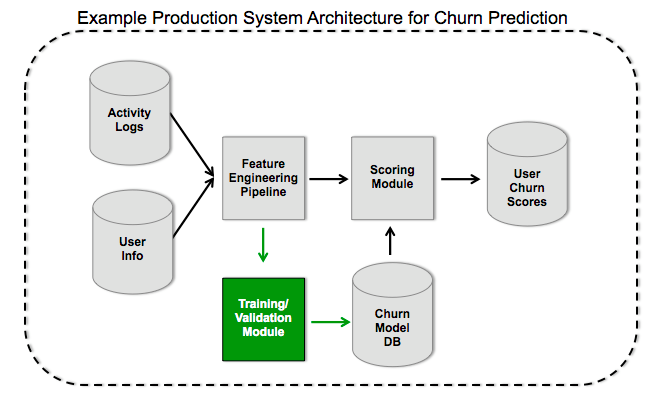

In [432]:
Image(filename='references/churn_architecture.png') 

<p>This extension should be fairly cheap, as we have already built out the feature engineering pipeline that performs much of the data processing. One interesting implication of the above design is that we need to automate a lot of the decision making above that we originally did manually. This is out of the scope of this case study, but this is one of the most exciting areas of industrial data science research!


</p>

##Wrap Up

<p>We have said a lot already, so this will be short! In this case study we tried to be thorough enough to cover all stages of defining, building and using a data science product in an industrial setting. Of course, an entire course can be taught on every element of this case study, so invariably, certain details have been left out. If you feel you have any suggestions on how to improve this case study, feel free to reach out at: briand at gmail dot com.

</p>
